In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

## データの読み込み

In [2]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')
gender_sub = pd.read_csv('../input/titanic/gender_submission.csv')

data = pd.concat([train, test], sort= False) ### train と test を結合したデータも用意

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [5]:
data.isnull().sum() ### 欠損しているデータの数を変数ごとに表示

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

## 欠損値の処理

上の結果から、Age・Cabin・Embarked・Fare に欠損値が存在することがわかった。欠損値が含まれたデータも分析に利用したいので、欠損値を埋めることを考える。まず Embarked から手を付ける。

In [6]:
### 文字で与えられているデータを扱える形にする
data['_Sex'] = pd.Categorical(data.Sex).codes
data['_Embarked'] = pd.Categorical(data.Embarked).codes
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,_Sex,_Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,2
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,2
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,2


male が 1、female が 0 になり、Embarked の S は 2、C は 0 になった

In [7]:
cols = ['Age','_Sex','_Embarked','Fare','Pclass','Survived']
data[cols].corr()

,Age,_Sex,_Embarked,Fare,Pclass,Survived
Age,1.000000,0.063645,-0.089292,0.178740,-0.408106,-0.077221
_Sex,0.063645,1.000000,0.104818,-0.185523,0.124617,-0.543351
_Embarked,-0.089292,0.104818,1.000000,-0.241442,0.192867,-0.176509
Fare,0.178740,-0.185523,-0.241442,1.000000,-0.558629,0.257307
Pclass,-0.408106,0.124617,0.192867,-0.558629,1.000000,-0.338481
Survived,-0.077221,-0.543351,-0.176509,0.257307,-0.338481,1.000000


In [8]:
data[data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,_Sex,_Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0,-1
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0,-1


上で出した相関行列から、Embarked と **Fare**、**Pclass** に弱い相関が見受けられる。そこで、これらを利用して Embark を埋めることを考える。

In [9]:
### data のうち、Pclass が 1 であるようなものを取り出す
val = data[data['Pclass'] == 1][['Fare','Embarked']]

### 取り出したデータを Embarked によってグループ分けし、それぞれのグループの Fare について平均などを算出
val.groupby(['Embarked'])['Fare'].agg(['count','mean','min','max','median'])

,count,mean,min,max,median
Embarked,,,,,
C,141,106.845330,25.7417,512.3292,76.7292
Q,3,90.000000,90.0000,90.0000,90.0000
S,177,72.148094,0.0000,263.0000,52.0000


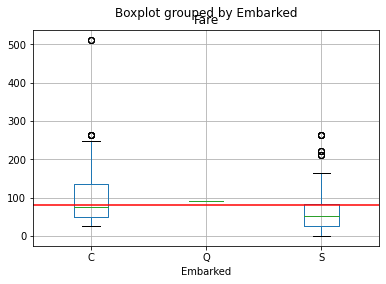

In [10]:
ax = val.boxplot(column='Fare',by='Embarked'); ### Embark で分けられた各グループの Fare の分布を示す箱ひげ図
ax.axhline(80, color='red') ### 二つのデータの Fare はどちらも 80 なので、そのラインに線を引いてみる

この結果によれば 'C' に属していそうなので、上の二つのデータの Embarked を C で埋める

In [11]:
data['Embarked'].fillna(('C'), inplace=True)

次に Fare を埋める

In [12]:
data[data['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,_Sex,_Embarked
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,1,2


In [13]:
data[cols].corr()['Fare'].abs().sort_values()

Age          0.178740
_Sex         0.185523
_Embarked    0.241442
Survived     0.257307
Pclass       0.558629
Fare         1.000000
Name: Fare, dtype: float64

Pclass と Embarked との相関があるので、欠損しているデータと Pclass、Embarked が同じ値のデータを取り出し、その中央値で埋めることにする

In [14]:
val = data[(data['Pclass'] == 3) & (data['_Embarked'] == 2)]['Fare']
val.agg(['count','mean','min','max','median'])

count     494.000000
mean       14.435422
min         0.000000
max        69.550000
median      8.050000
Name: Fare, dtype: float64

In [15]:
data.loc[152,'Fare'] = 8.05
data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
_Sex              0
_Embarked         0
dtype: int64

### Age を埋める

`fillna` が便利だが、勉強のため `sklearn.inpute` モジュールの `SimpleImputer` クラスを使用

In [16]:
data[data['Age'].isnull()].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,_Sex,_Embarked
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,1,1
17,18,1.0,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,1,2
19,20,1.0,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,0,0
26,27,0.0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,1,0
28,29,1.0,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,0,1


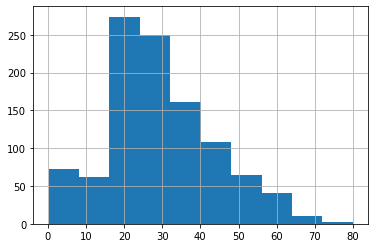

In [17]:
data['Age'].hist()

In [18]:
from sklearn.impute import SimpleImputer

X = data[['Age']]
imp = SimpleImputer(missing_values=np.nan, strategy='median') ### 分布が偏っているので、中央値で補完
imp.fit(X)
data['AgeMedian'] = imp.transform(X)
data[data['Age'].isnull()].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,_Sex,_Embarked,AgeMedian
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,1,1,28.0
17,18,1.0,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,1,2,28.0
19,20,1.0,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,0,0,28.0
26,27,0.0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,1,0,28.0
28,29,1.0,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,0,1,28.0


## 各特徴量と生存・死亡の関係を可視化

家族数、ぼっち乗船かどうか、という特徴量を追加

[参考](https://www.kaggle.com/sishihara/upura-kaggle-tutorial-03-feature-engineering)

In [19]:
data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
data['IsAlone'] = 0
data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1

train['FamilySize'] = data['FamilySize'][:len(train)]
test['FamilySize'] = data['FamilySize'][len(train):]

train['IsAlone'] = data['IsAlone'][:len(train)]
test['IsAlone'] = data['IsAlone'][len(train):]

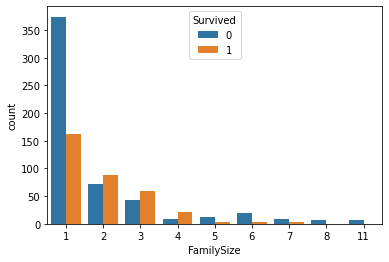

In [20]:
import seaborn as sns

sns.countplot(x='FamilySize', data=train, hue='Survived')

5人以上の大家族になると生存割合が逆転している

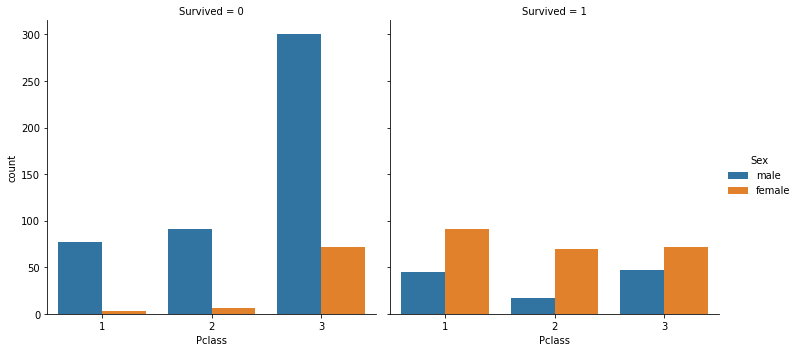

In [21]:
sns.catplot(x='Pclass', hue='Sex', col='Survived', data=train, kind='count')

基本的に男性よりも女性が生き残りがち

客室等級が2以上で生き残れなかった女性はごく少数

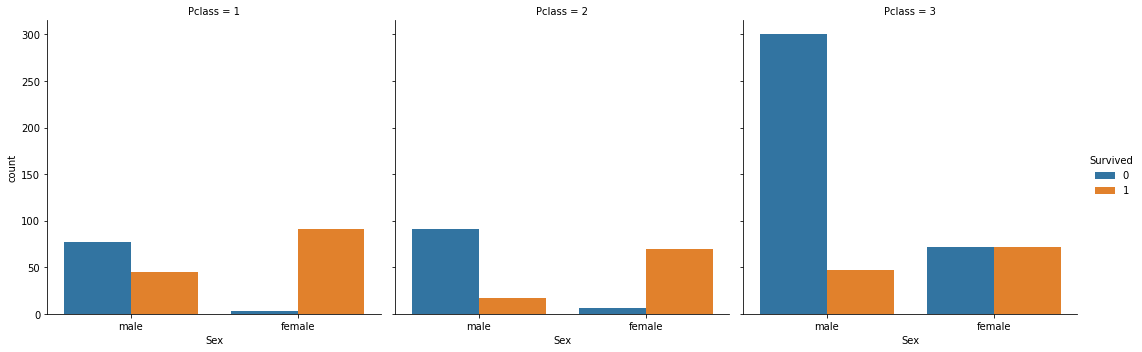

In [22]:
sns.catplot(x='Sex', hue='Survived', col='Pclass', data=train, kind='count')

`col` に客室階級を設定したバージョン。３等の部屋にいた女性が半々の確率で生き残ったことがわかる。

## 機械学習モデル

LightGBM を使用

In [23]:
delete_columns = ['Name', 'PassengerId','Ticket', 'Cabin','Embarked','Sex','Age']
data.drop(delete_columns, axis=1, inplace=True)

train = data[:len(train)]
test = data[len(train):]

y_train = train['Survived']
X_train = train.drop('Survived', axis=1)
X_test = test.drop('Survived', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0, stratify=y_train)
data.head()

,Survived,Pclass,SibSp,Parch,Fare,_Sex,_Embarked,AgeMedian,FamilySize,IsAlone
0,0.0,3,1,0,7.2500,1,2,22.0,2,0
1,1.0,1,1,0,71.2833,0,0,38.0,2,0
2,1.0,3,0,0,7.9250,0,2,26.0,1,1
3,1.0,1,1,0,53.1000,0,2,35.0,2,0
4,0.0,3,0,0,8.0500,1,2,35.0,1,1


In [24]:
categorical_features = ['_Embarked', 'Pclass', '_Sex'] ### カテゴリ変数を指定

In [25]:
import lightgbm as lgb


lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categorical_features)

params = {
    'objective': 'binary'
}

model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=10,
    num_boost_round=1000,
    early_stopping_rounds=10
)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.425241	valid_1's binary_logloss: 0.478975
[20]	training's binary_logloss: 0.344972	valid_1's binary_logloss: 0.444039
[30]	training's binary_logloss: 0.301357	valid_1's binary_logloss: 0.436304
[40]	training's binary_logloss: 0.265558	valid_1's binary_logloss: 0.43813
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.271351	valid_1's binary_logloss: 0.435623


In [26]:
y_pred = (y_pred > 0.5).astype(int) ### 0.5 以上なら「生存」と予測
sub = gender_sub
sub['Survived'] = y_pred
sub.to_csv("submission_lightgbm.csv", index=False)
sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
